# INFO-F-422 -  Statistical Foundations of Machine Learning 

### De Vos Sebastien - __[Sebastien.De.Vos@ulb.be](mailto:student1@ulb.ac.be) - Student ID 459907__
### Kalai Tarik - __[Tarik.Kalai@ulb.be](mailto:student2@ulb.ac.be) - Student ID 459631__
### Rubas Diego - __[Diego.Rubas@ulb.be](mailto:student3@ulb.ac.be) - Student ID 459733__

### Video presentation: www.youtube.com/abcd1234

## Project Title


### Table of Contents

* [Introduction](#Introduction)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
    * [Data Loading](#Data_Loading)
    * [Data Dimension](#Data_Dimension)
    * [Data Preview](#Data_Preview)
* [Data Preprocessing](#Data_Preprocessing)
    * [Missing Value Imputation](#Missing_Value_Imputation)
    * [Feature Engineering](#Feature_Engineering)
    * [Feature Selection](#Feature_Selection)
* [Model Selection](#Model_Selection)
    * [Model 1: Linear Model](#Model_1_Linear_Model)
    * [Model 2: Decision Tree](#Model_2_Decision_Tree)
        [Model 2.1: Bossted Decision Tree](#Model_2_1_Boosted_Decision_Tree)
    * [Model 3: Random Forest](#Model_3_Random_Forest)

# Introduction <a class="anchor" id="Introduction"></a>


# Exploratory Data Anaylsis <a class="anchor" id="Exploratory_Data_Analysis"></a>

In this section we will be viewing and understanding the data that we have.

## Data loading <a class="anchor" id="Data_Loading"></a>

In [56]:
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)
test_set_features <- read.csv("sample_data/test_set_features.csv", stringsAsFactors  = T)
submission_format <- read.csv("sample_data/submission_format.csv", stringsAsFactors  = T)
write.csv(submission_format,"sample_data/answers.csv", row.names = FALSE, quote=FALSE)
set.seed(12345)
head(submission_format)


,respondent_id,h1n1_vaccine,seasonal_vaccine
,<int>,<dbl>,<dbl>
1,26707,0.5,0.7
2,26708,0.5,0.7
3,26709,0.5,0.7
4,26710,0.5,0.7
5,26711,0.5,0.7
6,26712,0.5,0.7


               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          2.0                              
year           2022                             
month          04                               
day            22                               
svn rev        82229                            
language       R                                
version.string R version 4.2.0 (2022-04-22 ucrt)
nickname       Vigorous Calisthenics            

## Dimensions of the data samples. <a class="anchor" id="Data_Dimension"></a>

In [32]:
cat("dimension of test_set_features: ",  dim(test_set_features), "\n")# This will be the input to the model (after it had been trained), the answer the model
#will be providing will then be sent to DrivenData. 

cat("dimension of training_set_labels: ", dim(training_set_labels), "\n") # Answers to training_set_features. 

cat("dimension of training_set_features : ", dim(training_set_features), "\n") # Corresponding to a sample of data: will be used for training set and test set. 
#The result will then be "validated" with a comparison with training_set_labels

dimension of test_set_features:  26708 36 
dimension of training_set_labels:  26707 3 
dimension of training_set_features :  26707 36 


## Data Preview <a class="anchor" id="Data_Preview"></a>

In [33]:
# To generalise the function, we need to take into account the empty answers and not only NA. 
cleanData <- function(x) {
    res <- list() #From tarik : What is the use of res ???
    for (i in 2:22) {
        x <- transform_na(x, i)
    }
    return(x) #return
}

transform_na <- function(x, index){
    if (length(which(is.na(x[,index]))) > 0) { #Check if there is any NA in the column
            mean_ts <- mean(x[,index], na.rm = T) #compute old_mean
            sd_ts <- sqrt(var(x[,index], na.rm = T)) #compute old_sd
            feature_name <- names(x[index]) #remember the name of the feature we are dealing with
            x[is.na(x[,index]), index] <- round(mean_ts + sd_ts/2) #modify the data
        }
    return(x)
}

norm<-function(x){
    return( (x-min(x)) / (max(x)-min(x)) )
}

one_hot_encoding <- function(x, index) {
    names <- levels(x[,index]) # get the names of all the possible different values
    new_col <- model.matrix(~0+x[,index]) # transforms the column in a matrix with a '1' in the correct column and '0' otherwise
    attr(new_col, "dimnames")[[2]] <- names
    new_col <- as.data.frame(new_col)
    x <- data.frame(x[1:index-1],new_col,x[(index+1):ncol(x)])
    return(x)
}

cast_into_double <- function(x){
    for (i in 2:length(x)){
        x[,i] <- as.numeric(x[,i])
    }
    return(x)
}

In [34]:
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
test_set_features <- read.csv("sample_data/test_set_features.csv", stringsAsFactors  = T)
data_sorting <- function(x){
    # for feature 2 -> 22
    x <- cleanData(x)
    # for feature 23
    levels(x[,23]) <- c(1, 2, 3, 4, 5)

    # for feature 24
    levels(x[,24]) <- c(0, 1, 2, 4, 3)

    # for feature 25
    x <- one_hot_encoding(x, 25)

    # for feature 26 -> number 29
    x <- one_hot_encoding(x, 29)

    # for feature 27 -> number 31 !!! it need to be changed, it is not a good way to sort this data.
    levels(x[,31]) <- c(0, 2, 1, 3) 

    # for feature 28 -> number 32
    levels(x[,32])[1] <- 'marital_status_not_specified'
    x <- one_hot_encoding(x, 32)

    # for feature 29 -> number 35
    levels(x[,35])[1] <- 'rental_not_specified'
    x <- one_hot_encoding(x, 35)

    #for features 30 -> number 38
    levels(x[,38])[1] <- 'employment_not_specified'
    x <- one_hot_encoding(x, 38)
    
    # for feature 31 -> 42, we judged its contribution was negligeable against its cost of implementation
    x <- subset(x, select = -42)

    # for feature 32 -> 42 (since we dropped last column
    x <- one_hot_encoding(x, 42)

    # for feature 33 -> 45
    x <- transform_na(x, 45)

    # for feature 34 -> 46
    x <- transform_na(x, 46)

    # for feature 35 -> 47, we judged its contribution was negligeable against its cost of implementation
    x <- subset(x, select = -47)

    # for feature 36 -> 47, we judged its contribution was negligeable against its cost of implementation
    x <- subset(x, select = -47)



    x <- cast_into_double(x)
    name <- names(x)[-1]
    temp <- apply(x[2:length(x)], 2 , norm)
    attr(temp, "dimnames")[[2]] <- name
    x <- data.frame(x[1],as.data.frame(temp))
    return (x)
}

training_set_features <- data_sorting(training_set_features)
test_set_features <- data_sorting(test_set_features)

head(training_set_features[20:30])
dim(training_set_features)

,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,Black,Hispanic,Other.or.Multiple,White,Female,Male
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.25,0.00,0.25,0.75,0.25,0,0,0,1,1,0
2,0.75,0.25,0.75,0.25,0.50,0,0,0,1,0,1
3,0.75,0.00,0.25,0.00,0.75,0,0,0,1,0,1
4,1.00,0.75,0.00,1.00,0.50,0,0,0,1,1,0
5,0.50,0.00,0.75,0.50,1.00,0,0,0,1,1,0
6,1.00,0.75,0.75,1.00,0.50,0,0,0,1,0,1


[1] 26707    46

In [35]:
# par(mfrow=c(1,3))

# # data_to_plot <- table(training_set_features["h1n1_concern"])
# # data_to_plot <- table(t(training_set_features["h1n1_knowledge"]))

# names<-names(training_set_features)
# for(i in 2:length(names)){
#     barplot(table(training_set_features[names[i]]), col="blue", main=names[i],beside=T) 
# }

In [36]:
# # head(training_set_labels)
# # plot(training_set_labels$h1n1_vaccine, training_set_labels$vaccine_vaccine)

# training_set_features[1] <- training_set_labels[2]
# plot(training_set_features[1:3]) #Why is the plot so strange ?? 
# X1 <- as.matrix(training_set_features[1])
# X2 <- as.matrix(training_set_features[2])
# X3 <- as.matrix(training_set_features[3])
# regression <- lm( X1~ X2 + X3)

# summary(regression)

# Data preprocessing <a class="anchor" id="Data_Preprocessing"></a>

## Missing Value Imputation<a class="anchor" id="Missing_Value_Imputation"></a>

## Feature Engineering<a class="anchor" id="Feature_Engineering"></a>

## Feature Selection<a class="anchor" id="Feature_Selection"></a>



# Model selection <a class="anchor" id="Model_Selection"></a>



## Model 1 <a class="anchor" id="Model_1_Linear_Model"></a>


In [37]:
temp <- training_set_features[-c(28, 30, 33, 37, 41, 44)] # i just looked at which one made the computation impossible in a greedy manner.


n <- length(temp)-1 #length(training_set_features[2:t]) # number of features
p <- n+1
N <- length(training_set_features[,1]) # number of samples
N2 <- length(test_set_features[,1])
Y <- as.matrix(training_set_labels[2:3])
X <- as.matrix(cbind(array(1,c(N,1)),temp[2:p]))

beta_hat <- array(0, c(p,2))
sigma_hat_w <- numeric(2)
Y_hat <- array(0, c(N,2))

temp_2  <- test_set_features[-c(28, 30, 33, 37, 41, 44)]
X_final <-  as.matrix(cbind(array(1,c(N2,1)),temp_2[2:p]))
Y_final <- array(0, c(N2,2))


for (i in 1:2){
    beta_hat[,i] <- solve((t(X)%*%X))%*%t(X)%*%Y[,i] #doesn't work, we need to identify the features that are highly correlated and keep only one. 
    Y_hat[,i] <- X %*% beta_hat[,i]
    Y_final[,i] <- X_final %*% beta_hat[,i]
    e <- Y[,i] - Y_hat[,i]
    sigma_hat_w[i] <- sqrt((t(e)%*%e)/(N-p))
}
sigma_hat_w[1]
sigma_hat_w[2]

Y_final<-ifelse(Y_final<=0,0.01,Y_final)
Y_final<-ifelse(Y_final>=1,0.99,Y_final)
submission <- data.frame(submission_format[1],Y_final)

head(submission)
write.csv(submission,"sample_data/answers.csv", row.names = FALSE, quote=FALSE)

[1] 0.350802

[1] 0.4096301

,respondent_id,X1,X2
,<int>,<dbl>,<dbl>
1,26707,0.06282598,0.2397931
2,26708,0.01169483,0.0100000
3,26709,0.38061953,0.6088012
4,26710,0.50194488,0.8584078
5,26711,0.25134780,0.4908154
6,26712,0.42346578,0.9004768


## Model 2 <a class="anchor" id="Model_2_Decision_Tree"></a>

In [38]:
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2]) 
head(spam)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,employment_not_specified,Employed,Not.in.Labor.Force,Unemployed,MSA..Not.Principle..City,MSA..Principle.City,Non.MSA,household_adults,household_children,h1n1_vaccine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.3333333,0.0,0,0,0,0,0,1,1,0,⋯,0,0,1,0,0,0,1,0.0000000,0,0
2,1.0000000,1.0,0,1,0,1,0,1,1,0,⋯,0,1,0,0,1,0,0,0.0000000,0,0
3,0.3333333,0.5,0,1,0,0,0,0,0,0,⋯,0,1,0,0,1,0,0,0.6666667,0,0
4,0.3333333,0.5,0,1,0,1,1,0,0,0,⋯,0,0,1,0,0,1,0,0.0000000,0,0
5,0.6666667,0.5,0,1,0,1,1,0,1,0,⋯,0,1,0,0,1,0,0,0.3333333,0,0
6,1.0000000,0.5,0,1,0,1,0,0,1,0,⋯,0,1,0,0,0,1,0,0.6666667,1,0


In [39]:
library(rpart)
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2])
spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)
type <- names(spam)[length(spam)]
type

train_data <- spam[spam_idx[1:half_split],]
test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]

model <- rpart(form=h1n1_vaccine ~ ., method="class", data=train_data)

Y_pred <- predict(model,test_set_features)
submission_format[2] <- Y_pred[,2]

spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3])
spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)
type <- names(spam)[length(spam)]
type

train_data <- spam[spam_idx[1:half_split],]
test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]

model <- rpart(form=seasonal_vaccine ~ ., method="class", data=train_data)
Y_pred <- predict(model,test_set_features)
submission_format[3] <- Y_pred[,2]
head(submission_format)

write.csv(submission_format,"sample_data/answers.csv", row.names = FALSE, quote=FALSE)


[1] "h1n1_vaccine"

[1] "seasonal_vaccine"

,respondent_id,h1n1_vaccine,seasonal_vaccine
,<int>,<dbl>,<dbl>
1,26707,0.1304593,0.2355578
2,26708,0.1304593,0.2355578
3,26709,0.1304593,0.7907054
4,26710,0.3323171,0.6912955
5,26711,0.1304593,0.2925170
6,26712,0.1304593,0.7907054


## Model 2.bis <a class="anchor" id="Model_2_1_Boosted_Decision_Tree"></a>

In [40]:
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)
spam_bis <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3])
# spam_bis$h1n1_vaccine


In [57]:
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)

training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
test_set_features <- read.csv("sample_data/test_set_features.csv", stringsAsFactors  = T)
# training_set_features <- data_sorting(training_set_features)
training_set_features <- cleanData(training_set_features)
training_set_features <- transform_na(training_set_features, 33)
training_set_features <- transform_na(training_set_features, 34)
test_set_features <- cleanData(test_set_features)
test_set_features <- transform_na(test_set_features, 33)
test_set_features <- transform_na(test_set_features, 34)
# training_set_features <- subset(training_set_features, select = -35)
# training_set_features <- subset(training_set_features, select = -35)

spam_bis <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2])
library(tree)
# library(rpart)



# Parameters of the algorithm
n_trees <- 15
N <- nrow(spam_bis)


alpha_vec <- array(NA,n_trees)
misclassification_vec <- array(NA,n_trees)


# Rescaling target variable
# data(spam_bis)
spam_bis$h1n1_vaccine <- ifelse(spam_bis$h1n1_vaccine == 1,-1,1) # Data in {-1,+1}
# spam_bis$h1n1_vaccine
target_variable <- ncol(spam_bis)


# 50/50 data split
spam_idx <- sample(1:N)
half_split <- floor(N/2)
train_data <- spam_bis[spam_idx[1:half_split],]
test_data <- spam_bis[spam_idx[(half_split+1):nrow(spam_bis)],]


# Prediction - Single tree
tree_model <-tree(h1n1_vaccine ~ ., train_data,
                  control=tree.control(half_split,mincut=20))

# tree_model <-rpart(h1n1_vaccine ~ ., train_data,
#                   control=rpart.control(half_split,mincut=10))

Y_pred_tree <- sign(predict(tree_model,test_data))

# Boosting
Y_pred_boosting <- rep(0,length(test_data))
w <- array(1/half_split,half_split)
# set.seed(555)

# For each boosting iteration
for(j in 1:n_trees){
    
    #1. Sample from the training set
    selected_samples <- sample(1:half_split,1,replace=TRUE,prob=w)
    print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
    
    #2. Fit a model on the training set and evaluate it on the training set
     tree_model <-tree(h1n1_vaccine ~ ., train_data[selected_samples,],
                  control=tree.control(half_split,mincut=20))
#     tree_model <-rpart(h1n1_vaccine ~ ., train_data[selected_samples,],
#                   control=rpart.control(half_split,mincut=10))
    Y_pred_train <- sign(predict(tree_model,train_data))
    #3. Compute misclassification on training set
    misclassification_vec[j] <- sum(w*as.double(train_data$h1n1_vaccine != sign(Y_pred_train)))/sum(w)
#     cat("Checking the missclassification value : ",misclassification_vec[j], " At the run : ", j, "\n")
    
    #4. Computation of alpha and updating of resampling weight
    alpha_vec[j] <- log((1-misclassification_vec[j])/misclassification_vec[j])  
    w <- w * exp(alpha_vec[j]*as.integer(train_data$h1n1_vaccine != sign(Y_pred_train)))
#     cat("Checking if there is an NA in w : ", mean(w), " At the run : ", j, "\n")
    
    
    #5. Normalize the weights in order to represent a true distribution
    
    w <- w/sum(w)

    
    #6. Compute the predictions on the testing set and weight them by alpha
    Y_pred_boosting<-Y_pred_boosting+alpha_vec[j]*predict(tree_model,test_data)


}

# Misclassification error comparation
misclassification_error_base <- sum(as.numeric(test_data$h1n1_vaccine != sign(Y_pred_tree)))/length(Y_pred_tree)
misclassification_error_boosting <- sum(as.numeric(test_data$h1n1_vaccine != sign(Y_pred_boosting)))/length(Y_pred_boosting)

print(paste("[INFO] - Misclassification rate - Single tree:",misclassification_error_base))
print(paste("[INFO] - Misclassification rate - Boosted tree:",misclassification_error_boosting))


[1] "[INFO] - Training set size: 13353 - Testing set size 13354"


Warning message in Y_pred_boosting + alpha_vec[j] * predict(tree_model, test_data):
“longer object length is not a multiple of shorter object length”


[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Misclassification rate - Single tree: 0.204882432230043"
[1] "[INFO] - Miscl


## Model 3 <a class="anchor" id="Model_3_Random_Forest"></a>


In [42]:
install.packages("randomForest")

Installing package into ‘/home/seb/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



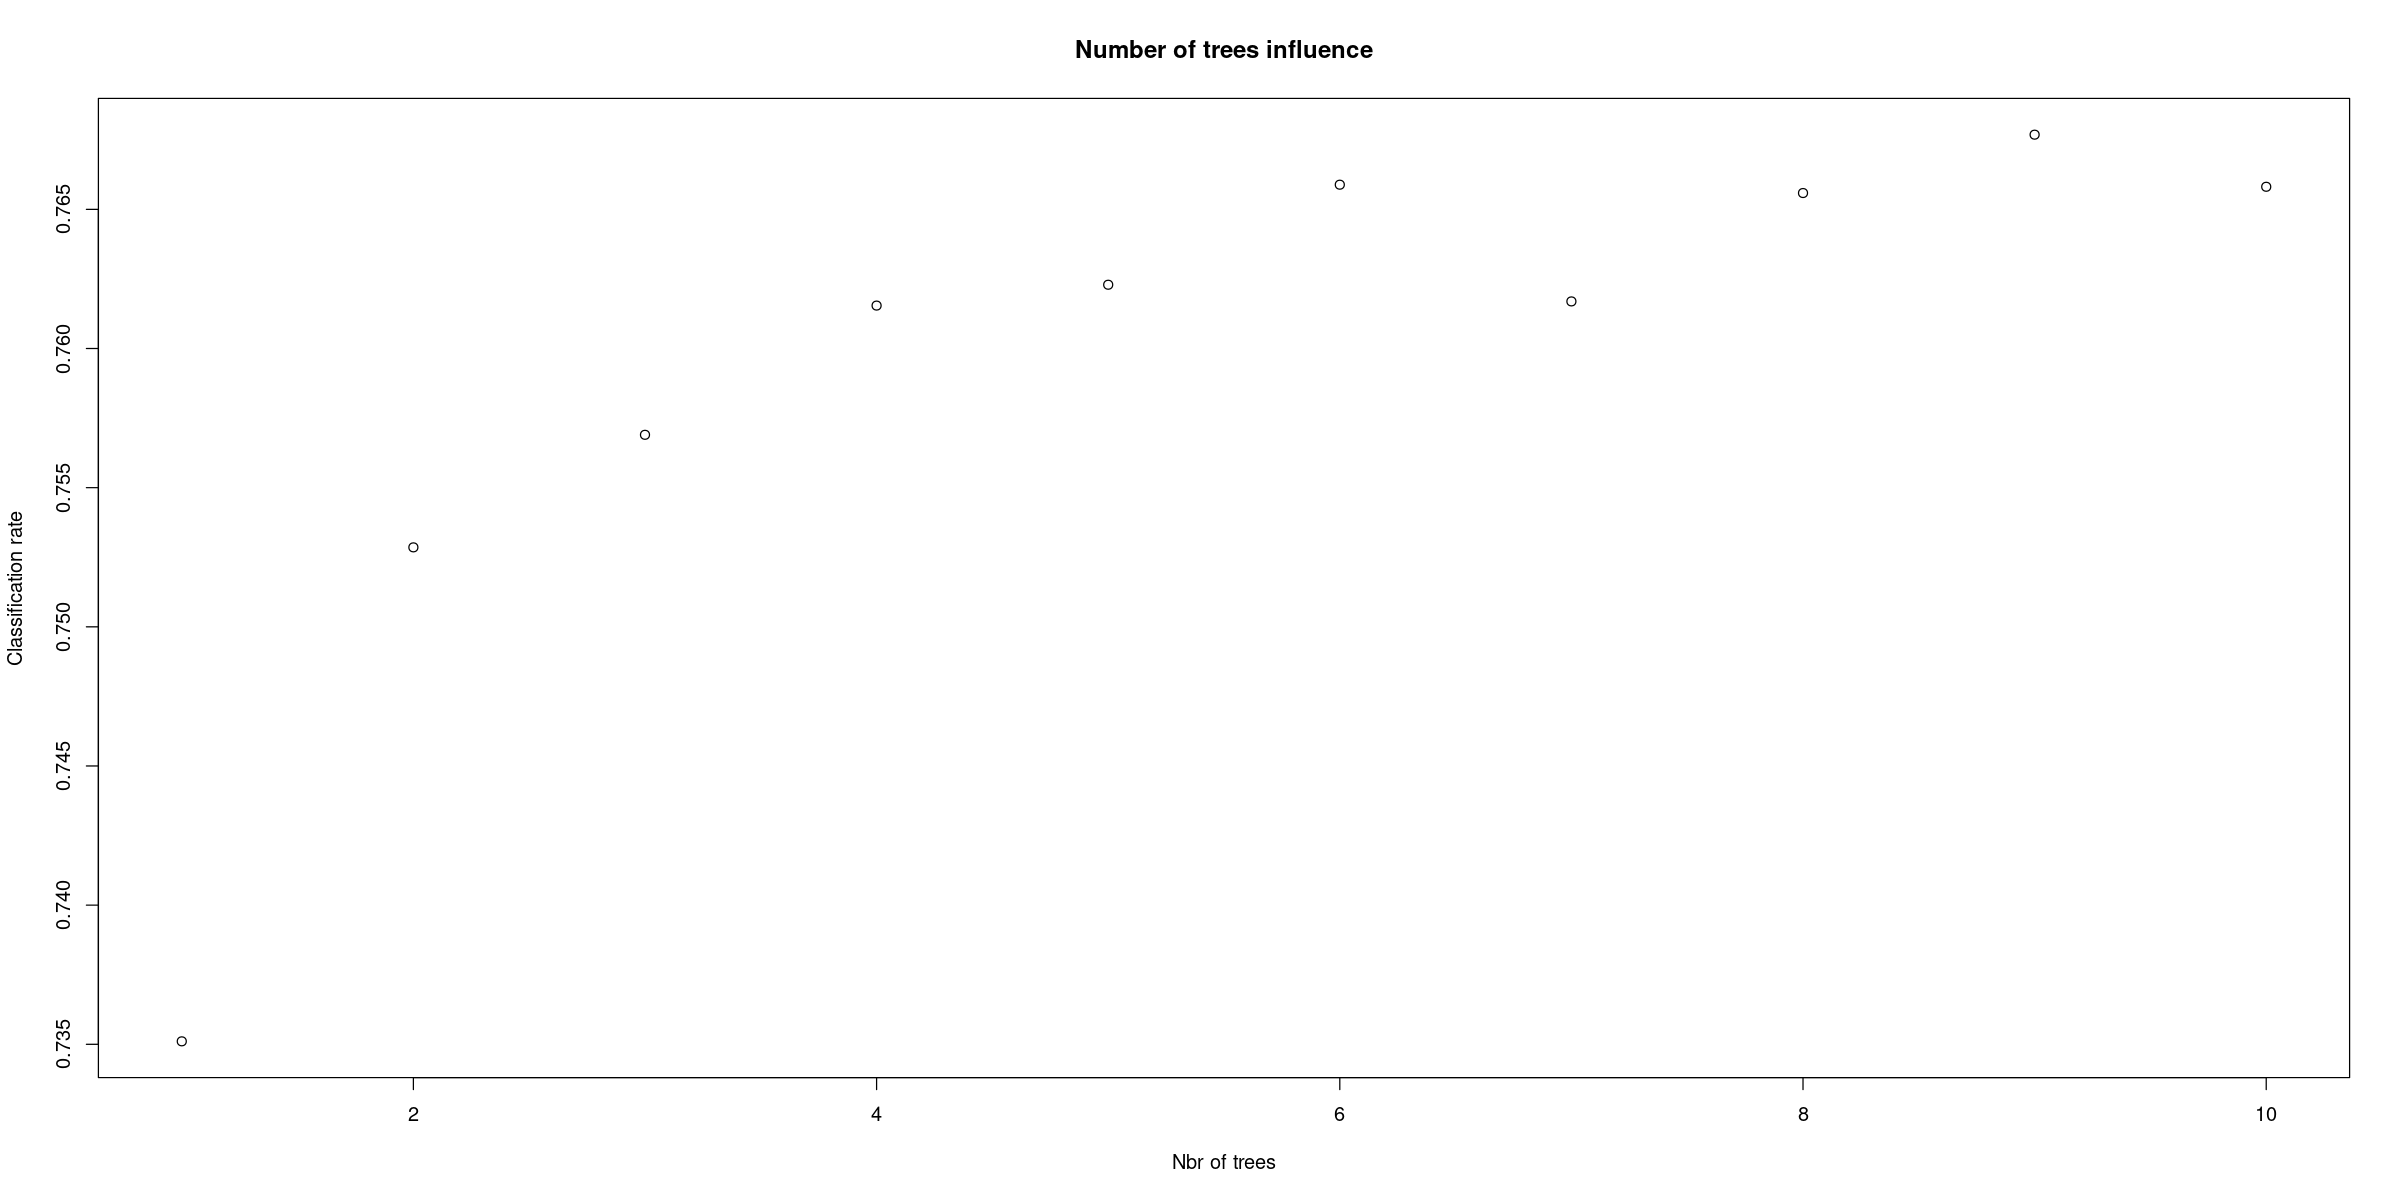

In [45]:
library("randomForest")
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3]) 
n_trees <- 10
accuracy_vec <- array(0,n_trees)

spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)

for (i in 1:n_trees){ #print(i)
    #3.1 Take the first half of the dataset as a training data set
    train_data <- spam[spam_idx[1:half_split],]

    #3.2 Take the second half of the dataset as a hold out or test data set
    test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]
    
    model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=i*10)
    
    accuracy_vec[i] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    }
plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")

In [ ]:
 ?numeric()

In [ ]:
install.packages("randomForest")

Installing package into ‘/home/seb/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [59]:
library("randomForest")
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2]) 
head(spam)
head(test_set_features)
# head(spam)
n_trees <- 100 # 600 = 0.8385 precision
threshold <- 0.5


accuracy_vec <- array(0,n_trees)

spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)

train_data <- spam[spam_idx[1:half_split],]

test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]
    
model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=n_trees, 
                          keep.forest=TRUE)

Y_pred <- data.frame(predict(model,test_set_features[2:length(test_set_features)]))
submission <- data.frame(submission_format[1], Y_pred)



spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3]) 
n_trees <- 90 # 800 = 0.772 precision
accuracy_vec <- array(0, n_trees)

spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)

train_data <- spam[spam_idx[1:half_split],]

test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]
    
model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=n_trees, 
                          keep.forest=TRUE)

Y_pred <- data.frame(predict(model, test_set_features[2:length(test_set_features)]))
submission <- data.frame(submission, Y_pred)
x <- submission
levels(x[,2]) <- c("0.0", "1.0")
levels(x[,3]) <- c("0.0", "1.0")
write.csv(x,"sample_data/answers.csv", row.names = FALSE, quote=FALSE)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<int>
1,1,0,0,0,0,0,0,1,1,0,⋯,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0,0,,,0
2,3,2,0,1,0,1,0,1,1,0,⋯,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0,0,pxcmvdjn,xgwztkwe,0
3,1,1,0,1,0,0,0,0,0,0,⋯,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2,0,rucpziij,xtkaffoo,0
4,1,1,0,1,0,1,1,0,0,0,⋯,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0,0,,,0
5,2,1,0,1,0,1,1,0,1,0,⋯,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1,0,wxleyezf,emcorrxb,0
6,3,1,0,1,0,1,0,0,1,0,⋯,Married,Own,Employed,atmpeygn,"MSA, Principle City",2,3,saaquncn,vlluhbov,0


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,26707,2,2,0,1,0,1,1,0,1,⋯,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1,0,atmlpfrs,hfxkjkmi
2,26708,1,1,0,0,0,0,0,0,0,⋯,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3,0,atmlpfrs,xqwwgdyp
3,26709,2,2,0,0,1,1,1,1,1,⋯,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1,0,nduyfdeo,pvmttkik
4,26710,1,1,0,0,0,0,0,0,0,⋯,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1,0,,
5,26711,3,1,1,1,0,1,1,1,1,⋯,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0,1,fcxhlnwr,mxkfnird
6,26712,2,2,0,1,0,1,1,0,1,⋯,"> $75,000",Not Married,Own,Employed,mlyzmhmf,"MSA, Principle City",0,2,fcxhlnwr,cmhcxjea



#### Example of simple equation
\begin{equation}
e = mc^2
\end{equation}

#### Example of matrix equation - Cross product formula:

\begin{equation*}
\mathbf{V}_1 \times \mathbf{V}_2 =  
\begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial X}{\partial u} &  \frac{\partial Y}{\partial u} & 0 \\
\frac{\partial X}{\partial v} &  \frac{\partial Y}{\partial v} & 0
\end{vmatrix}
\end{equation*}

#### Example of multiline equation - The Lorenz Equations:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

#### Example of Markdown Table:

| This | is   |
|------|------|
|   a  | table|


# Alternative models





# Conclusions